# Import Libraries and Load Data:

- Load Libraries
- change working directory
- unzip input data
- remove zip data

In [ ]:
import pandas as pd
import numpy as np
import os
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
os.chdir(r'/content/drive/MyDrive/AppliedAI/self_case_study_1/ashrae_energy_prediction')

In [ ]:
!unzip 'data/input_data/ashrae-energy-prediction.zip' -d 'data/input_data'

In [ ]:
os.remove('data/input_data/ashrae-energy-prediction.zip')

In [ ]:
#https://towardsdatascience.com/how-to-reduce-the-size-of-a-pandas-dataframe-in-python-7ed6e4269f88
def compress(df, verbose=True):
    ## downcasting loop
    start_mem = np.round(df.memory_usage().sum() / 1024**2, 3)
    for column in df:
        if df[column].dtype == 'float64':
            df[column]=pd.to_numeric(df[column], downcast='float')
        if (df[column].dtype== 'int64') or (df[column].dtype== 'int32'):
            df[column]=pd.to_numeric(df[column], downcast='integer')
    end_mem = np.round(df.memory_usage().sum() / 1024**2, 3)
    if verbose:
        print(f"Memory usage reduced to {end_mem:8} MB: Memory reduction by {(start_mem-end_mem)*100/start_mem}%")
    return df

def read_building_data(input_data_path):
    return compress(pd.read_csv(os.path.join(input_data_path, 'building_metadata.csv')))
def read_train_data(input_data_path):
    return compress(pd.read_csv(os.path.join(input_data_path, 'train.csv'), parse_dates=['timestamp']))
def read_test_data(input_data_path):
    return compress(pd.read_csv(os.path.join(input_data_path, 'test.csv'), parse_dates=['timestamp']))
def read_weather_train_data(input_data_path):
    return compress(pd.read_csv(os.path.join(input_data_path, 'weather_train.csv'), parse_dates=['timestamp']))
def read_weather_test_data(input_data_path):
    return compress(pd.read_csv(os.path.join(input_data_path, 'weather_test.csv'), parse_dates=['timestamp']))
def read_all_data(input_data_path):
    return read_building_data(input_data_path), read_train_data(input_data_path),\
           read_test_data(input_data_path), read_weather_train_data(input_data_path),\
           read_weather_test_data(input_data_path)

In [ ]:
building_metadata_df, train_df, test_df, weather_train_df, weather_test_df = read_all_data('data/input_data')

In [ ]:
pickle.dump(building_metadata_df, open('data/input_data/building_metadata_df.pkl', 'wb'))
pickle.dump(train_df, open('data/input_data/train_df.pkl', 'wb'))
pickle.dump(test_df, open('data/input_data/test_df.pkl', 'wb'))
pickle.dump(weather_train_df, open('data/input_data/weather_train_df.pkl', 'wb'))
pickle.dump(weather_test_df, open('data/input_data/weather_test_df.pkl', 'wb'))

# Preprocess

## building data

In [ ]:
def preprocess_building_data(building_metadata_df, train=True):
    df = building_metadata_df.copy()
    #floor_count
    df['floor_count'].fillna(0, inplace=True)
    df['floor_count'] = (df['floor_count'] + 1).astype(np.int8)
    #square_feet
    df['log_sq_ft'] = np.log(df['square_feet']).astype(np.float16)
    #primary_use
    df['primary_use'] = df.primary_use.str.lower().replace(re.compile(r'(/| )'), "_")
    if train:
        primary_use_label = sorted(df.primary_use.unique())
        primary_use_label_map = {label:i for i, label in enumerate(primary_use_label, start=1)}
        primary_use_label_map['UNK'] = 0
        pickle.dump(primary_use_label_map, open('data/processed_data/primary_use_label_map.pkl', 'wb'))
    else:
        primary_use_label_map = pickle.load(open('data/processed_data/primary_use_label_map.pkl', 'rb'))
    df['primary_use'] = df.primary_use.replace(primary_use_label_map).astype(np.int8)
    #year_built
    bins = np.arange(0, 201, 25)
    labels = np.arange(1, bins.shape[0])
    df['year_built'] = df['year_built'] - 1900 + 1
    df['year_built_label'] = pd.cut(df['year_built'], bins = bins , labels = labels,
                             include_lowest = True, ordered=False).astype(np.float16).fillna(0).astype(np.int8)
    df['year_built'] = df['year_built'].fillna(0).astype(np.int32)
    df = compress(df)
    assert df.isna().sum().sum() == 0
    return df

## weather data

In [ ]:
def preprocess_weather_data(weather_df, train=True):
    df = weather_df.copy()
    min_year = df.timestamp.dt.year.min()
    max_year = df.timestamp.dt.year.min()
    delta = 1
    year_index = pd.date_range(f'{min_year}-01-01', f'{max_year+delta}-01-01', freq='H', closed='left')
    df_list = []
    site_id_with_missing_value = []
    for site_id in range(16):
        df_site = df[df['site_id']==site_id]\
                    .set_index('timestamp').reindex(year_index)\
                    .interpolate(method='linear', limit_direction='both')
        try:
            assert (df_site.isna().sum().sum()==0)
        except AssertionError:
            print("Site id: ", site_id)
            print("Shape: ", df_site.shape)
            print(df_site.isna().sum())
            site_id_with_missing_value.append(site_id)
            print("="*40)
        df_list.append(df_site)

    p_weather_df = pd.concat(df_list).reset_index().rename(columns={'index':'timestamp'})

    columns = p_weather_df.columns
    df_site_list_2 = []
    for site_id in site_id_with_missing_value:
        df_site =  p_weather_df[p_weather_df['site_id'] == site_id]
        col_na = columns[df_site.isna().sum() > 0]
        for column in col_na:
            new_value = p_weather_df[p_weather_df['site_id'] == 0][column].values
            p_weather_df.loc[(p_weather_df['site_id'] == site_id), column] = new_value

    bins = np.arange(0, 361, 45)
    labels = np.arange(1, bins.shape[0])
    df['wind_direction_label'] = pd.cut(df['wind_direction'], bins = bins , labels = labels,
                                        include_lowest = True, ordered=False).astype(np.float16)\
                                        .fillna(0).astype(np.int8)
    return p_weather_df

In [ ]:
def preprocess_train_data(train_df):
    df = train_df.copy()
    df.dropna(inplace=True)
    df['log_meter_reading'] = np.log1p(df['meter_reading'])
    return df

# First Cut Solution

- First Cut Solution:<br>
As a first cut solution we can start with simple moving average,
weighted moving average and exponential moving average model
- Alternate Solution:<br>
    - Above solution cannot be applied here as we are not having immediate past reading at our disposal. We are provided with 2016 meter reading and we need to predict 2017-2018 (2 year reading).
    - Further we can leverage weather metadata and building metadata to
build linear models like logistic regression and other non linear model
like SVR(kernel based), RF, GBDT.


In [ ]:
#load raw compressed data
train_df = pickle.load(open('data/input_data/train_df.pkl', 'rb'))
weather_train_df = pickle.load(open('data/input_data/weather_train_df.pkl', 'rb'))
building_metadata_df = pickle.load(open('data/input_data/building_metadata_df.pkl', 'rb'))

In [ ]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [ ]:
train_df.isna().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

In [ ]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.0,NaN,1019.700012,0.0,0.0
1,0,2016-01-01 01:00:00,24.400000,NaN,21.1,-1.0,1020.200012,70.0,1.5
2,0,2016-01-01 02:00:00,22.799999,2.0,21.1,0.0,1020.200012,0.0,0.0
3,0,2016-01-01 03:00:00,21.100000,2.0,20.6,0.0,1020.099976,0.0,0.0
4,0,2016-01-01 04:00:00,20.000000,2.0,20.0,-1.0,1020.000000,250.0,2.6


In [ ]:
weather_train_df.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [ ]:
building_metadata_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [ ]:
building_metadata_df.isna().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

In [ ]:
#preprocess raw compressed data
p_train_df = preprocess_train_data(train_df)
p_weather_train_df = preprocess_weather_data(weather_train_df)
p_building_metadata_df = preprocess_building_data(building_metadata_df)

In [ ]:
p_train_df.isna().sum()

building_id          0
meter                0
timestamp            0
meter_reading        0
log_meter_reading    0
dtype: int64

In [ ]:
p_weather_train_df.isna().sum()

timestamp             0
site_id               0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

In [ ]:
p_building_metadata_df.isna().sum()

site_id             0
building_id         0
primary_use         0
square_feet         0
year_built          0
floor_count         0
log_sq_ft           0
year_built_label    0
dtype: int64

In [ ]:
pickle.dump(p_building_metadata_df, open('data/processed_data/p_building_metadata_df.pkl', 'wb'))
pickle.dump(p_train_df, open('data/processed_data/p_train_df.pkl', 'wb'))
pickle.dump(p_weather_train_df, open('data/processed_data/p_weather_train_df.pkl', 'wb'))

## Prepare Data

In [ ]:
p_building_metadata_df = pickle.load(open('data/processed_data/p_building_metadata_df.pkl', 'rb'))
p_train_df = pickle.load(open('data/processed_data/p_train_df.pkl', 'rb'))
p_weather_train_df = pickle.load(open('data/processed_data/p_weather_train_df.pkl', 'rb'))

In [ ]:
final_data = p_train_df.merge(p_building_metadata_df, on=['building_id'], how='left')\
                       .merge(p_weather_train_df, on=['site_id', 'timestamp'], how='left')
final_data.head(2)

,building_id,meter,timestamp,meter_reading,log_meter_reading,site_id,primary_use,square_feet,year_built,floor_count,log_sq_ft,year_built_label,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0.0,0,1,7432,109,1,8.914062,5,25.0,6.0,20.0,-1.0,1019.700012,0.0,0.0
1,1,0,2016-01-01,0.0,0.0,0,1,2720,105,1,7.910156,5,25.0,6.0,20.0,-1.0,1019.700012,0.0,0.0


In [ ]:
def add_time_based_features(data):
    df = data.copy()
    df['dayofweek'] = df.timestamp.dt.dayofweek
    df['hour'] = df.timestamp.dt.hour
    return df

In [ ]:
def FE(data):
    df = data.copy()
    df = df.assign(floor_sq_ft = df['log_sq_ft'] * df['floor_count'])
    return df

In [ ]:
final_data = add_time_based_features(final_data)
final_data = FE(final_data)

In [ ]:
final_data.isna().sum()

building_id           0
meter                 0
timestamp             0
meter_reading         0
log_meter_reading     0
site_id               0
primary_use           0
square_feet           0
year_built            0
floor_count           0
log_sq_ft             0
year_built_label      0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dayofweek             0
hour                  0
floor_sq_ft           0
dtype: int64

## Time Based Split

In [ ]:
final_data_train, final_data_test = final_data[final_data.timestamp.dt.month <= 6], final_data[final_data.timestamp.dt.month > 6]

In [ ]:
final_data_train.head()

,building_id,meter,timestamp,meter_reading,log_meter_reading,site_id,primary_use,square_feet,year_built,floor_count,log_sq_ft,year_built_label,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0.0,0,1,7432,109,1,8.914062,5,25.0,6.0,20.0,-1.0,1019.700012,0.0,0.0
1,1,0,2016-01-01,0.0,0.0,0,1,2720,105,1,7.910156,5,25.0,6.0,20.0,-1.0,1019.700012,0.0,0.0
2,2,0,2016-01-01,0.0,0.0,0,1,5376,92,1,8.585938,4,25.0,6.0,20.0,-1.0,1019.700012,0.0,0.0
3,3,0,2016-01-01,0.0,0.0,0,1,23685,103,1,10.070312,5,25.0,6.0,20.0,-1.0,1019.700012,0.0,0.0
4,4,0,2016-01-01,0.0,0.0,0,1,116607,76,1,11.664062,4,25.0,6.0,20.0,-1.0,1019.700012,0.0,0.0


In [ ]:
X_pre_train = final_data_train.drop(columns=['meter_reading', 'log_meter_reading', 'square_feet',
                                             'year_built'])
y_pre_train = final_data_train['log_meter_reading']

X_pre_test = final_data_test.drop(columns=['meter_reading', 'log_meter_reading', 'square_feet',
                                           'year_built'])
y_pre_test = final_data_test['log_meter_reading']

In [ ]:
#sample 100 building for our first-cut solution
sample_100_building = np.random.choice(1449, 100, replace=False)
sample_100_building[:10]

array([1288, 1216,  874, 1177, 1115, 1181,  698,   62,  274, 1112])

In [ ]:
X_pre_train_sampled = X_pre_train.loc[X_pre_train.building_id.isin(sample_100_building)]
y_pre_train_sampled = y_pre_train.loc[X_pre_train.building_id.isin(sample_100_building)]

X_pre_test_sampled = X_pre_test.loc[X_pre_test.building_id.isin(sample_100_building)]
y_pre_test_sampled = y_pre_test.loc[X_pre_test.building_id.isin(sample_100_building)]

In [ ]:
X_pre_train_sampled.shape, y_pre_train_sampled.shape

((686694, 15), (686694,))

In [ ]:
if not os.path.exists('data/experiment'):
    os.makedirs('data/experiment')

In [ ]:
pickle.dump(X_pre_train_sampled, open('data/experiment/X_pre_train_sampled.pkl', 'wb'))
pickle.dump(y_pre_train_sampled, open('data/experiment/y_pre_train_sampled.pkl', 'wb'))
pickle.dump(X_pre_test_sampled, open('data/experiment/X_pre_test_sampled.pkl', 'wb'))
pickle.dump(y_pre_test_sampled, open('data/experiment/y_pre_test_sampled.pkl', 'wb'))

In [ ]:
from lightgbm import LGBMRegressor, early_stopping

In [ ]:
model = LGBMRegressor()

In [ ]:
feature_name = list(X_pre_train_sampled.columns)
feature_name.remove('timestamp')
feature_name

['building_id',
 'meter',
 'site_id',
 'primary_use',
 'floor_count',
 'log_sq_ft',
 'year_built_label',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed']

In [ ]:
categorical_feature = ['building_id', 'meter', 'site_id', 'primary_use','year_built_label', 'wind_direction']

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
X_test = X_pre_test_sampled.drop(columns='timestamp')
X_test.columns

Index(['building_id', 'meter', 'site_id', 'primary_use', 'floor_count',
       'log_sq_ft', 'year_built_label', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'],
      dtype='object')

In [ ]:
y_test = y_pre_test_sampled

In [ ]:
month_list = [2,4]
models = []
results = []
for month in month_list:
    X_train = X_pre_train_sampled[X_pre_train_sampled.timestamp.dt.month <= month].drop(columns='timestamp')
    y_train = y_pre_train_sampled[X_pre_train_sampled.timestamp.dt.month <= month]

    X_val = X_pre_train_sampled[X_pre_train_sampled.timestamp.dt.month > month].drop(columns='timestamp')
    y_val = y_pre_train_sampled[X_pre_train_sampled.timestamp.dt.month > month]

    model = LGBMRegressor()
    model.fit(X_train, y_train,  eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='rmse',
              feature_name= list(X_train.columns),
              categorical_feature= categorical_feature,
              callbacks=[early_stopping(10)], verbose=101)
    
    y_hat_test = model.predict(X_test)

    models.append(model)
    results.append(mean_squared_error(y_test, y_hat_test))

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'meter', 'primary_use', 'site_id', 'wind_direction', 'year_built_label']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[27]	valid_0's l2: 2.80413	valid_0's rmse: 1.67455


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'meter', 'primary_use', 'site_id', 'wind_direction', 'year_built_label']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[13]	valid_0's l2: 3.26719	valid_0's rmse: 1.80754


In [ ]:
results

[4.95401073286346, 4.13460979401772]

In [ ]:
model.feature_importances_

array([199, 106,   1,   0,   4,  26,   1,  49,   0,   4,   0,   0,   0,
         0])

In [ ]:
feature_name

['building_id',
 'meter',
 'site_id',
 'primary_use',
 'floor_count',
 'log_sq_ft',
 'year_built_label',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed']

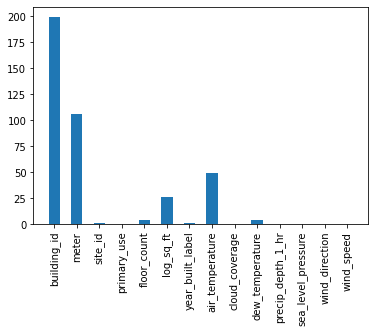

In [ ]:
plt.bar(x=list(np.arange(14)),
        height=model.feature_importances_,
        width=0.5)
plt.xticks(list(np.arange(14)), labels=feature_name, rotation=90)
plt.show()

### Observation:
- building_id , meter, air_temperature are 3 most important feature
- other features are log_sq_ft, dew_temperature, floor_count and site_id
- features which were not used are: primary_use, cloud_coverage, precip_depth_1_hr, sea_level_pressure, wind_direction, wind_speed 

# Experiment

In [ ]:
from lightgbm import LGBMRegressor, early_stopping

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
import datetime

'20220816-070739'

In [ ]:
class experiment():
    def __init__(self, data, root_path='./project/results.csv'):
        self.data = data.copy()
        # self.models = dict()
        # self.results = dict()
        # self.features = dict()
        self.root_path = root_path
        if os.path.exists(root_path):
            self.results = pd.read_csv(root_path)
        else:
            self.results = pd.DataFrame(columns=['experiment_name', 'description', 'model',
                                                 'result', 'features','categorical_feature',
                                                 'train_data',
                                                 'val_data'])
        self.curr_model = None

    def prepare(self, name, feature, split_month=6, description=''):
        if (name == self.results.experiment_name).any():
            assert False, f"experiment {name} already exists please provide different name"

        data_train = self.data[self.data.timestamp.dt.month <= split_month]
        data_test = self.data[self.data.timestamp.dt.month > split_month]

        X_pre_train = data_train[feature + ['timestamp']]
        y_pre_train = data_train['log_meter_reading']

        X_pre_test = data_test[feature + ['timestamp']]
        y_pre_test = data_test['log_meter_reading']

        #sample 100 building for our first-cut solution
        sample_100_building = np.random.choice(1449, 500, replace=False)

        X_pre_train_sampled = X_pre_train.loc[X_pre_train.building_id.isin(sample_100_building)]
        y_pre_train_sampled = y_pre_train.loc[X_pre_train.building_id.isin(sample_100_building)]

        X_pre_test_sampled = X_pre_test.loc[X_pre_test.building_id.isin(sample_100_building)]
        y_pre_test_sampled = y_pre_test.loc[X_pre_test.building_id.isin(sample_100_building)]

        return (X_pre_train_sampled, y_pre_train_sampled, X_pre_test_sampled, y_pre_test_sampled)


    def run(self, name, feature, categorical_feature, month_list, split_month=6, description=''):
        X_pre_train_sampled, y_pre_train_sampled, X_pre_test_sampled, y_test = self.prepare(name, feature,
                                                                                            split_month,
                                                                                            description)
        X_test = X_pre_test_sampled.drop(columns='timestamp')

        for month in month_list:
            X_train = X_pre_train_sampled[X_pre_train_sampled.timestamp.dt.month <= month].drop(columns='timestamp')
            X_train = X_train[feature]
            y_train = y_pre_train_sampled[X_pre_train_sampled.timestamp.dt.month <= month]

            X_val = X_pre_train_sampled[X_pre_train_sampled.timestamp.dt.month > month].drop(columns='timestamp')
            X_val = X_val[feature]
            y_val = y_pre_train_sampled[X_pre_train_sampled.timestamp.dt.month > month]

            self.curr_model = LGBMRegressor()
            self.curr_model.fit(X_train, y_train,  eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='rmse',
                                feature_name= feature,
                                categorical_feature= categorical_feature,
                                callbacks=[early_stopping(10)], verbose=101)
            
            y_hat_test = self.curr_model.predict(X_test[feature])
            result = mean_squared_error(y_test, y_hat_test)
            model_path = os.path.join('model', f"{name}-{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}.pkl")
            pickle.dump(self.curr_model, open(model_path,'wb'))

            my_dict = {'experiment_name':name,
                       'description':description,
                       'model':model_path,
                       'result':result,
                       'features':[feature],
                       'categorical_feature':[categorical_feature],
                       'train_data':split_month,
                       'val_data':month}
            self.results = pd.concat([self.results, pd.DataFrame(my_dict)], ignore_index=True)
        self.results.to_csv(self.root_path, index=False)

    def get_results(self):
        return self.results

    def plot_feature_importance(self, model=None, feature=None):
        if model is not None:
            self.curr_model = model
        if self.curr_model is None:
            print("Please provide model and feature name to evaluate")
        else:
            if feature is not None:
                plt.bar(x=list(np.arange(len(feature))),
                        height=self.curr_model.feature_importances_,
                        width=0.5)
                plt.xticks(list(np.arange(len(feature))), labels=feature, rotation=90)
                plt.show()
            else:
                print("Please provide list of valid feature names")

## Iteration 1

About Experiment:
- We sampled random 500 building for our experiment
- Took first 6 month as our train data and remaining 6 month as test data
- We used time based features like dayofweek and hour
- Results:
    - train rmse: 0.7841466108731613
    - val rmse: 1.5566608880111874
    - test rmse: 3.479901
- Conclusion:
    - There is huge difference between train and test rmse
    - Clearly model is not generalizing well
    - This could be due to change meter reading distribution between train and test data
    - We can further improve performance by cleaning data

In [ ]:
expt = experiment(final_data)

In [ ]:
feature = ['building_id', 'meter', 'site_id', 'primary_use',
           'floor_count', 'log_sq_ft', 'year_built_label',
           'air_temperature', 'cloud_coverage', 'dew_temperature',
           'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
           'wind_speed', 'dayofweek', 'hour']
categorical_feature = ['building_id', 'meter', 'site_id', 'primary_use', 
                       'year_built_label', 'wind_direction', 'hour', 'dayofweek']

In [ ]:
final_data.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading',
       'log_meter_reading', 'site_id', 'primary_use', 'square_feet',
       'year_built', 'floor_count', 'log_sq_ft', 'year_built_label',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'dayofweek', 'hour'],
      dtype='object')

In [ ]:
expt.run(name='expt1', feature=feature, categorical_feature=categorical_feature,
         month_list=[2,4], split_month=6, description='first_cut_solution')

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'site_id', 'wind_direction', 'year_built_label']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[11]	training's l2: 1.32161	training's rmse: 1.14961	valid_1's l2: 2.91635	valid_1's rmse: 1.70773


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'site_id', 'wind_direction', 'year_built_label']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.614886	training's rmse: 0.784147	valid_1's l2: 2.42319	valid_1's rmse: 1.55666


In [ ]:
df = expt.get_results()
df.head()

,experiment_name,description,model,result,features,categorical_feature,train_data,val_data
0,expt1,first_cut_solution,LGBMRegressor(),4.015130,"[building_id, meter, site_id, primary_use, flo...","[building_id, meter, site_id, primary_use, yea...",6,2
1,expt1,first_cut_solution,LGBMRegressor(),3.479901,"[building_id, meter, site_id, primary_use, flo...","[building_id, meter, site_id, primary_use, yea...",6,4


In [ ]:
df.loc[0, 'model'].best_score_

defaultdict(dict,
            {'training': {'l2': 1.3216050179969252,
              'rmse': 1.1496108115344623},
             'valid_1': {'l2': 2.9163523442424504,
              'rmse': 1.7077331009974746}})

In [ ]:
df.loc[1, 'model'].best_score_

defaultdict(dict,
            {'training': {'l2': 0.614885907343865, 'rmse': 0.7841466108731613},
             'valid_1': {'l2': 2.4231931202637784,
              'rmse': 1.5566608880111874}})

In [ ]:
X = final_data[['meter_reading', 'timestamp', 'site_id', 'building_id', 'meter']].set_index('timestamp')
Y_train = X.loc[X.index.month <= 6, 'meter_reading']
Y_test = X.loc[X.index.month > 6, 'meter_reading']

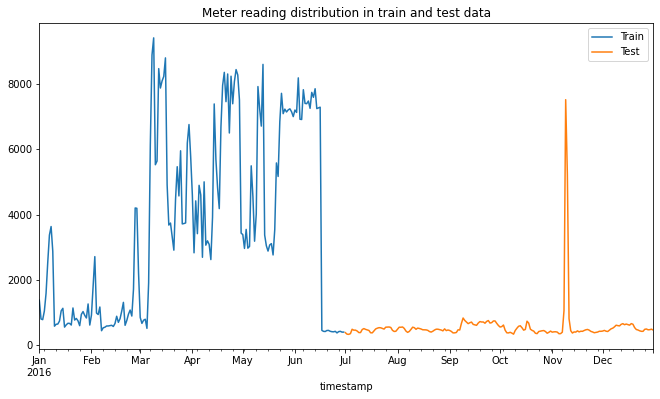

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(11,6))
Y_train.resample('D').mean().plot(ax=axs, label='Train')
Y_test.resample('D').mean().plot(ax=axs, label='Test')
axs.legend()
axs.set_title("Meter reading distribution in train and test data")
plt.show()

In [ ]:
# X = final_data[['meter_reading', 'timestamp', 'site_id', 'building_id', 'meter']].set_index('timestamp')
Y_train = X.loc[(X.index.month <= 6) & (X.building_id != 1099), 'meter_reading']
Y_test = X.loc[(X.index.month > 6) & (X.building_id != 1099), 'meter_reading']

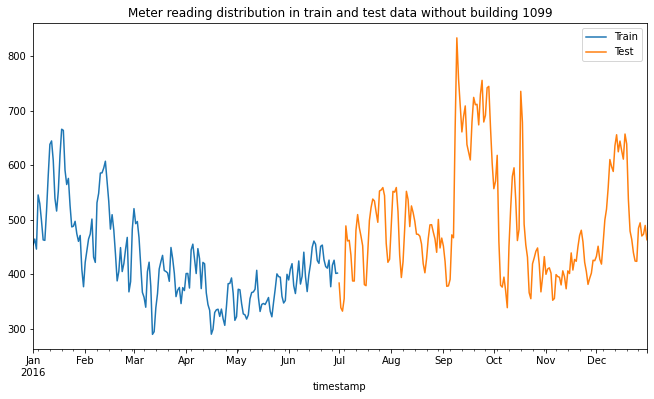

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(11,6))
Y_train.resample('D').mean().plot(ax=axs, label='Train')
Y_test.resample('D').mean().plot(ax=axs, label='Test')
axs.legend()
axs.set_title("Meter reading distribution in train and test data without building 1099")
plt.show()

## Iteration 2

About Experiments:
- We increase our train data from 4 to 6 month (January - June)
- We would use 7-8 as our validation month (July and August)
- Remaining 9,10,11,12 will be used as test data (September - December)


In [ ]:
expt = experiment(final_data)

In [ ]:
feature = ['building_id', 'meter', 'site_id', 'primary_use',
           'floor_count', 'log_sq_ft', 'year_built_label',
           'air_temperature', 'cloud_coverage', 'dew_temperature',
           'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
           'wind_speed', 'dayofweek', 'hour']
categorical_feature = ['building_id', 'meter', 'site_id', 'primary_use', 
                       'year_built_label', 'wind_direction', 'hour', 'dayofweek']

In [ ]:
expt.run(name='expt2', feature=feature, categorical_feature=categorical_feature,
         month_list=[5,7], split_month=8, description='train data month increased to 6')

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'site_id', 'wind_direction', 'year_built_label']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.861604	training's l2: 0.742361	valid_1's rmse: 1.47934	valid_1's l2: 2.18844


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'primary_use', 'site_id', 'wind_direction', 'year_built_label']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.918674	training's l2: 0.843962	valid_1's rmse: 1.03205	valid_1's l2: 1.06513


In [ ]:
expt.get_results()

,experiment_name,description,model,result,features,categorical_feature,train_data,val_data
0,expt1,first_cut_solution,LGBMRegressor(),4.015130,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",6,2
1,expt1,first_cut_solution,LGBMRegressor(),3.479901,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",6,4
2,expt2,train data month increased to 6,LGBMRegressor(),2.444116,"[building_id, meter, site_id, primary_use, flo...","[building_id, meter, site_id, primary_use, yea...",8,5
3,expt2,train data month increased to 6,LGBMRegressor(),1.997163,"[building_id, meter, site_id, primary_use, flo...","[building_id, meter, site_id, primary_use, yea...",8,7


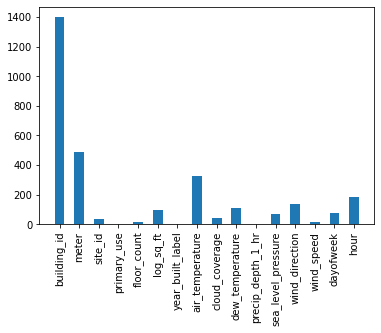

In [ ]:
expt.plot_feature_importance(model=expt.get_results()['model'][2], feature=feature)

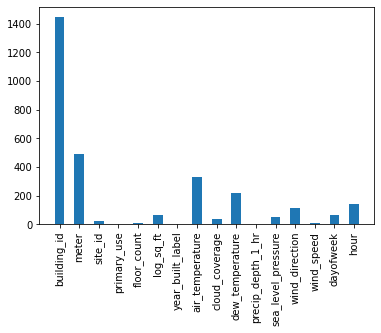

In [ ]:
expt.plot_feature_importance(feature=feature)

## Iteration 3:

About Experiments:
- Remove unused columns like primary_use, year_built_label, precip_depth_1_hr
- Also we would combine floor_count and square_feet column

In [ ]:
feature = ['building_id', 'meter', 'site_id', 
           'floor_sq_ft',
           'air_temperature', 'cloud_coverage', 'dew_temperature',
           'sea_level_pressure', 'wind_direction',
           'wind_speed', 'dayofweek', 'hour']
categorical_feature = ['building_id', 'meter', 'site_id', 
                       'wind_direction', 'hour', 'dayofweek']

expt.run(name='expt3', feature=feature, categorical_feature=categorical_feature,
         month_list=[5,7], split_month=8, description='remove unused features')

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'site_id', 'wind_direction']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.858297	training's l2: 0.736673	valid_1's rmse: 1.50249	valid_1's l2: 2.25747


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'site_id', 'wind_direction']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 0.913326	training's l2: 0.834164	valid_1's rmse: 0.933835	valid_1's l2: 0.872048


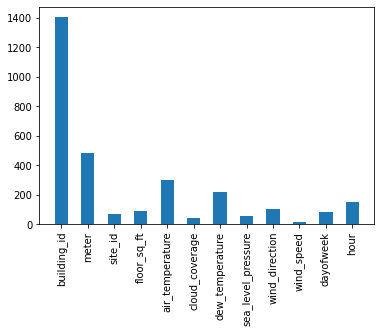

In [ ]:
expt.plot_feature_importance(feature=feature)

In [ ]:
expt.get_results()

,experiment_name,description,model,result,features,categorical_feature,train_data,val_data
0,expt1,first_cut_solution,LGBMRegressor(),4.015130,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",6,2
1,expt1,first_cut_solution,LGBMRegressor(),3.479901,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",6,4
2,expt2,train data month increased to 6,LGBMRegressor(),2.444116,"[building_id, meter, site_id, primary_use, flo...","[building_id, meter, site_id, primary_use, yea...",8,5
3,expt2,train data month increased to 6,LGBMRegressor(),1.997163,"[building_id, meter, site_id, primary_use, flo...","[building_id, meter, site_id, primary_use, yea...",8,7
4,expt3,remove unused features,LGBMRegressor(),2.689460,"[building_id, meter, site_id, floor_sq_ft, air...","[building_id, meter, site_id, wind_direction, ...",8,5
5,expt3,remove unused features,LGBMRegressor(),2.171603,"[building_id, meter, site_id, floor_sq_ft, air...","[building_id, meter, site_id, wind_direction, ...",8,7


## Iteration 4:

About Experiments:
- Remove building id 1099

In [ ]:
expt = experiment(final_data)

In [ ]:
expt.data = expt.data[expt.data['building_id'] != 1099]

In [ ]:
feature = ['building_id', 'meter', 'site_id', 
           'floor_sq_ft',
           'air_temperature', 'cloud_coverage', 'dew_temperature',
           'sea_level_pressure', 'wind_direction',
           'wind_speed', 'dayofweek', 'hour']
categorical_feature = ['building_id', 'meter', 'site_id', 
                       'wind_direction', 'hour', 'dayofweek']

expt.run(name='expt4', feature=feature, categorical_feature=categorical_feature,
         month_list=[5,7], split_month=8, description='Without 1099')

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'site_id', 'wind_direction']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.692736	training's rmse: 0.832308	valid_1's l2: 2.08689	valid_1's rmse: 1.44461


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'dayofweek', 'hour', 'meter', 'site_id', 'wind_direction']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 10 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.804011	training's rmse: 0.896667	valid_1's l2: 0.952906	valid_1's rmse: 0.976169


In [ ]:
expt.get_results()

,experiment_name,description,model,result,features,categorical_feature,train_data,val_data
0,expt1,first_cut_solution,LGBMRegressor(),4.015130,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",6,2
1,expt1,first_cut_solution,LGBMRegressor(),3.479901,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",6,4
2,expt2,train data month increased to 6,LGBMRegressor(),2.444116,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",8,5
3,expt2,train data month increased to 6,LGBMRegressor(),1.997163,"['building_id', 'meter', 'site_id', 'primary_u...","['building_id', 'meter', 'site_id', 'primary_u...",8,7
4,expt3,remove unused features,LGBMRegressor(),2.689460,"['building_id', 'meter', 'site_id', 'floor_sq_...","['building_id', 'meter', 'site_id', 'wind_dire...",8,5
5,expt3,remove unused features,LGBMRegressor(),2.171603,"['building_id', 'meter', 'site_id', 'floor_sq_...","['building_id', 'meter', 'site_id', 'wind_dire...",8,7
6,expt4,Without 1099,LGBMRegressor(),2.333531,"[building_id, meter, site_id, floor_sq_ft, air...","[building_id, meter, site_id, wind_direction, ...",8,5
7,expt4,Without 1099,LGBMRegressor(),1.942578,"[building_id, meter, site_id, floor_sq_ft, air...","[building_id, meter, site_id, wind_direction, ...",8,7


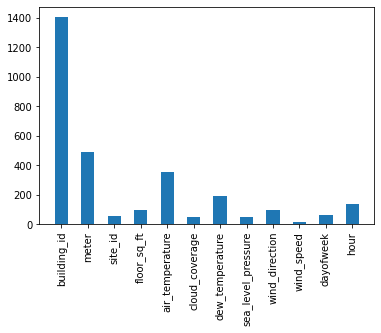

In [ ]:
expt.plot_feature_importance(feature=feature)